## Description
In this notebook the similarities from one word to a given word pool fo mobility words is calculated using word embeddings form BERT.

#### Result
This approach is suitable, but can be fine tuned using SBERT.

The code was created with the assistance of ChatGPT-4.

In [86]:
# from transformers import AutoTokenizer, AutoModelForMaskedLM

# tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")
# model = AutoModelForMaskedLM.from_pretrained("google-bert/bert-base-german-cased")

In [87]:
from transformers import AutoTokenizer, AutoModel
import torch
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

# Load tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-german-cased")
model = AutoModel.from_pretrained("google-bert/bert-base-german-cased")

In [88]:
# Example for mobility terms
mobility_words = [
    "Verkehr", "Transport", "Fahrzeug", "Strasse", "Fahrplan", "Auto", "Bahn", "Mobilität",
    "Fahrrad", "Bus", "E-Mobilität", "ÖV", "Flughafen", "Lkw", "Velo"
]


In [89]:
def get_embedding(text):
    # Tokenize and convert to tensors
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True, max_length=512)
    
    # Forward pass through the model
    with torch.no_grad():
        outputs = model(**inputs)
    
    # We take the [CLS] token as the representation of the text
    # outputs.last_hidden_state is a tensor of shape (batch_size, sequence_length, hidden_size)
    # We take the first token ([CLS] token) and extract the embedding
    embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
    
    return embedding

# Example words
word_true = "Autobahn"
word_false = "Apfel"

# Calculate the embeddings of the example word
text_embedding_true = get_embedding(word_true)
text_embedding_false = get_embedding(word_false)

# Calculate embeddings of the mobility terms
mobility_embeddings = [get_embedding(term) for term in mobility_words]


In [90]:
# Calculate cosine similarity
similarities_true = cosine_similarity([text_embedding_true], mobility_embeddings)
similarities_false = cosine_similarity([text_embedding_false], mobility_embeddings)

# Find most similar terms
similarity_scores_true = similarities_true[0]
similarity_dict_true = {mobility_words[i]: similarity_scores_true[i] for i in range(len(mobility_words))}

similarity_scores_false = similarities_false[0]
similarity_dict_false = {mobility_words[i]: similarity_scores_false[i] for i in range(len(mobility_words))}

# Sort by highest similarity
sorted_similarity_true = sorted(similarity_dict_true.items(), key=lambda item: item[1], reverse=True)
sorted_similarity_false = sorted(similarity_dict_false.items(), key=lambda item: item[1], reverse=True)

# calculate the average
average_score_true = sum(similarity_scores_true) / len(similarity_scores_true)
average_score_false = sum(similarity_scores_false) / len(similarity_scores_false)

# take the top 5 similar words
top_5_true = sorted_similarity_true[:5]
top_5_false = sorted_similarity_false[:5]

top_5_words_true = [word for word, _ in top_5_true]
top_5_scores_true = [score for _, score in top_5_true]

top_5_words_false = [word for word, _ in top_5_false]
top_5_scores_false = [score for _, score in top_5_false]

# calculate the average again
top_5_average_score_true = sum(top_5_scores_true) / len(top_5_scores_true)
top_5_average_score_false = sum(top_5_scores_false) / len(top_5_scores_false)


for term, score in top_5_true:
    print(f"{term}: {score:.4f}")
print(f"\nAverage similarity to the word {word_true}: {average_score_true:.4f}")
print(f"\nAverage similarity of the top 5 to the word {word_true}: {top_5_average_score_true:.4f}")
print()
print()
for term, score in top_5_false:
    print(f"{term}: {score:.4f}")
print(f"\nAverage similarity to the word {word_false}: {average_score_false:.4f}")
print(f"\nAverage similarity of the top 5 to the word {word_false}: {top_5_average_score_false:.4f}")

Bahn: 0.8439
Bus: 0.8335
Strasse: 0.8225
Verkehr: 0.8175
Flughafen: 0.7972

Average similarity to the word Autobahn: 0.7609

Average similarity of the top 5 to the word Autobahn: 0.8229


Auto: 0.7446
Velo: 0.7341
Fahrrad: 0.7274
E-Mobilität: 0.7205
Mobilität: 0.7167

Average similarity to the word Apfel: 0.6991

Average similarity of the top 5 to the word Apfel: 0.7287


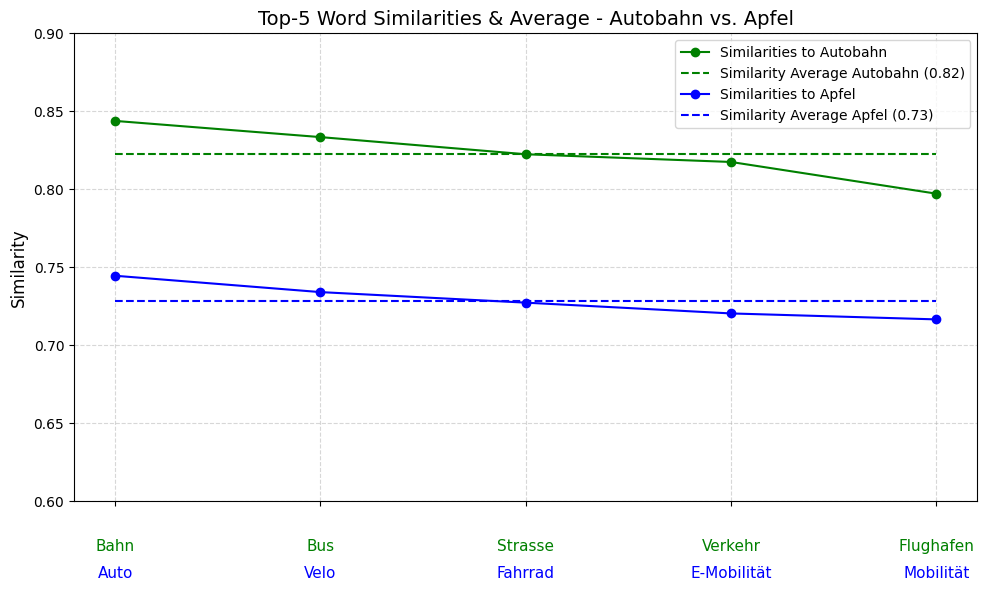

In [100]:
import matplotlib.pyplot as plt
from matplotlib import ticker

plt.figure(figsize=(10, 6))
x_pos = range(5)

# Plot True scores
plt.plot(x_pos, top_5_scores_true, 'o-', label=f'Similarities to {word_true}', color='green')
plt.hlines(top_5_average_score_true, x_pos[0], x_pos[-1], colors='green', linestyles='dashed', label=f'Similarity Average {word_true} ({round(top_5_average_score_true, 2)})')

# Plot False scores
plt.plot(x_pos, top_5_scores_false, 'o-', label=f'Similarities to {word_false}', color='blue')
plt.hlines(top_5_average_score_false, x_pos[0], x_pos[-1], colors='blue', linestyles='dashed', label=f'Similarity Average {word_false} ({round(top_5_average_score_false, 2)})')

# Set empty x-ticks, then manually place colored text
plt.xticks(x_pos, [""] * 5)
ax = plt.gca()

for i, (w_true, w_false) in enumerate(zip(top_5_words_true, top_5_words_false)):
    ax.text(i, -0.08, w_true, ha='center', va='top', color='green', fontsize=11, transform=ax.get_xaxis_transform())
    ax.text(i, -0.17, w_false, ha='center', va='bottom', color='blue', fontsize=11, transform=ax.get_xaxis_transform())

# Styling
plt.ylim(0.6, 0.9)
plt.ylabel("Similarity", fontsize=12)
plt.title(f"Top-5 Word Similarities & Average - {word_true} vs. {word_false}", fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()
